In [1]:
from main import *

In [2]:
sigma = 0.5
k = 500
min = 50

In [3]:
input_path = "data/VOC2012_test/JPEGImages/2008_000200.jpg"

Height:  375
Width:   500
Execution time: 0 minute(s) and 15 seconds


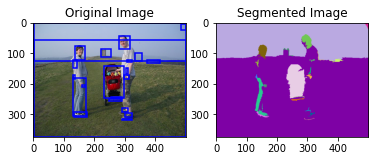

In [4]:
univ, bb = segment(input_path, sigma, k, min)

In [5]:
df_bndbox = parse_XML("data/VOC2012_test/Annotations/2008_000200.xml")

In [6]:
df_bndbox

,name,xmin,ymin,xmax,ymax
0,person,119,76,184,311
1,person,266,43,338,323


In [8]:
tuple(df_bndbox.values[:,1:][0][2:])

(184, 311)

In [9]:
df_bndbox.iloc[:,1:]["ymax"][0]

311

In [10]:
l = bb.get_bndbox("98646")

In [11]:
l1 = (int(l[0][0]%bb.w),int(l[1][1]/bb.w))
r1 = (int(l[0][1]%bb.w),int(l[1][0]/bb.w))
l2 = (df_bndbox.iloc[:,1:]["xmin"][0],df_bndbox.iloc[:,1:]["ymax"][0])
r2 = (df_bndbox.iloc[:,1:]["xmax"][0],df_bndbox.iloc[:,1:]["ymin"][0])

In [12]:
np.abs(l1[0] - r1[0])

44

In [13]:
def overlap(l1, r1, l2, r2):
    x = 0
    y = 1
    
    area1 = np.abs(l1[x] - r1[x]) * np.abs(l1[y] - r1[y])
    area2 = np.abs(l2[x] - r2[x]) * np.abs(l2[y] - r2[y])
    
    x_dist = np.abs(np.min([r1[x], r2[x]]) - np.max([l1[x], l2[x]]))
    
    y_dist = np.abs(np.max([l1[y], l2[y]]) - np.min([r1[y], r2[y]]))
    
    areaI = 0
    
    if x_dist > 0 and y_dist > 0:
        areaI = x_dist * y_dist
    else:
        return 0
        
    return areaI/(area1 + area2 - areaI)

In [14]:
l1,r1

((127, 306), (171, 178))

In [15]:
l2,r2

((119, 311), (184, 76))

In [16]:
overlap(l1,r1,l2,r2)

0.9785180278224662

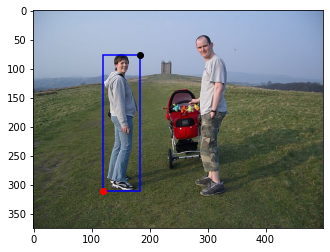

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(plt.imread(input_path))
rect = patches.Rectangle((df_bndbox.iloc[:,1:]["xmin"][0],df_bndbox.iloc[:,1:]["ymin"][0]),
                         df_bndbox.iloc[:,1:]["xmax"][0] - df_bndbox.iloc[:,1:]["xmin"][0],
                         df_bndbox.iloc[:,1:]["ymax"][0] - df_bndbox.iloc[:,1:]["ymin"][0],
                linewidth=1.5, edgecolor='b', facecolor='none')
ax.add_patch(rect)
ax.scatter(l2[0],l2[1],color="red")
ax.scatter(r2[0],r2[1],color="black")


In [18]:
list(bb.bndbox.keys())[12]

'98646'

In [45]:
overlap_05 = {} 

for i in range(df_bndbox.shape[0]):
    overlap_05[i] = ('None',0)
    for comp in bb.get_bndbox_id():
    
        l1 = (int(bb.get_bndbox(comp)[0][0]%bb.w),int(bb.get_bndbox(comp)[1][1]/bb.w))
        r1 = (int(bb.get_bndbox(comp)[0][1]%bb.w),int(bb.get_bndbox(comp)[1][0]/bb.w))
        l2 = (df_bndbox.iloc[:,1:]["xmin"][i],df_bndbox.iloc[:,1:]["ymax"][i])
        r2 = (df_bndbox.iloc[:,1:]["xmax"][i],df_bndbox.iloc[:,1:]["ymin"][i])
        
        tmp = overlap(l1,r1,l2,r2)

        if tmp > 0.5 and tmp > overlap_05[i][1]:
            max_ov = tmp
            print(i,comp, tmp)
            overlap_05[i] = (comp,tmp)

0 45663 0.780267629566695
0 52738 1.1063162024323263
0 127259 14.584584584584585
1 33304 0.8323529411764706
1 157319 0.8779048321652527


In [46]:
overlap_05

{0: ('127259', 14.584584584584585), 1: ('157319', 0.8779048321652527)}

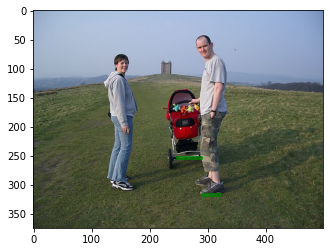

In [52]:
fig, ax = plt.subplots()
ax.imshow(plt.imread(input_path))
for gt in overlap_05:
    
    pt = bb.get_bndbox(overlap_05[gt][0])

    rect = patches.Rectangle((2+(pt[0][0]%bb.w), 2+(pt[1][0]/bb.w)),
                                 ((pt[0][1]%bb.w)-2) - (pt[0][0]%bb.w)+2,
                                 ((pt[1][1]/bb.w)-2) - (pt[1][0]/bb.w),
                linewidth=1.5, edgecolor='g', facecolor='none')

    ax.add_patch(rect)


# Higra - watershed

In [72]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

Image size: (375, 500)


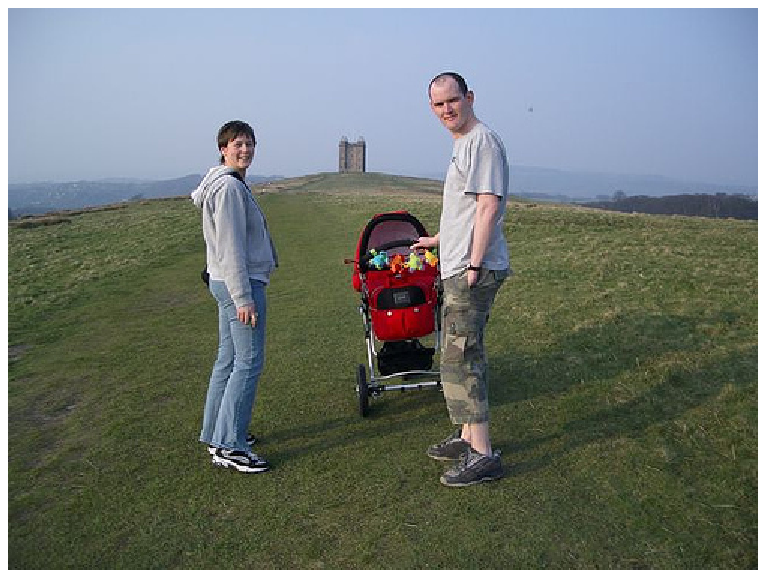

(<Figure size 750x562.5 with 1 Axes>, <Axes:>)

In [73]:
image = imageio.imread(input_path)
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float32)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

In [82]:
#!pip uninstall opencv-contrib-python

In [81]:
#!pip install opencv-python opencv-contrib-python --user

In [80]:
detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
gradient_image = detector.detectEdges(image)

imshow(gradient_image)

AttributeError: module 'cv2' has no attribute 'ximgproc'

In [61]:
graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)

NameError: name 'gradient_image' is not defined

In [58]:
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(tree, altitudes))**0.5)

NameError: name 'graph' is not defined